In [1]:
%matplotlib inline

# Basic imports

In [2]:
import pandas as pd
# import numpy as np
from Bio import SeqIO

from matplotlib import pyplot as plt
from scipy import stats

# import glob
import sklearn.metrics


###This is just for setting up the creation of new results folders
import datetime
year = datetime.date.today().year
month = datetime.date.today().month
import os
figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)
    


# Plotting parameters

In [3]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['axes.titlesize'] = 10

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.5'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True



# Helper functions

In [4]:
from supporting_functions import *

# Read in basic information

In [5]:
prot_name = '1AOE_A'
length_cutoff = 8.0
primary_chain_distance = 12
number_to_test = 1
contact_file_loc = '../Data/Contact_matrices/{}_CA_contacts.csv'.format(prot_name)
df_contacts = pd.read_csv(contact_file_loc, index_col=0)
df_contacts, df_contacts_stack = process_contacts_df(df_contacts, primary_chain_distance)


records = list(SeqIO.parse('../Data/fastas/{}.rosetta.fasta'.format(prot_name), 'fasta'))
assert len(records)==1
seq = str(records[0].seq)
df_couplings = pd.read_csv('../Data/Simulated_couplings/1AOE_A_thresh=0.1_nMuts=1920_nSeqs=3000.ccmpred.processed.couplings', sep=',')
df_couplings_stack, df_couplings_pivot = process_couplings_df(df_couplings, df_contacts, primary_chain_distance)
merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)
ppv, counts = ppv_from_df(merged_df, number_to_test, length_cutoff=length_cutoff)
            
####Testing
merged_df['contact'] = np.where(merged_df['distance']>=length_cutoff, 0, 1)
print('PPV', ppv)
print('AUROC', sklearn.metrics.roc_auc_score(merged_df['contact'], merged_df['couplings']))
print('Avg Pre', sklearn.metrics.average_precision_score(merged_df['contact'], merged_df['couplings']))

PPV 1.0
AUROC 0.6401114755140642
Avg Pre 0.19871722815455262


In [6]:
merged_df.head()

,aa1_loc,aa2_loc,distance,primary_chain_distance,couplings,aa1_aa,aa2_aa,contact
3039,18,145,5.987902,127,2.020427,G,M,1
3364,20,147,5.071209,127,1.627773,G,T,1
8339,55,117,5.999142,62,1.082960,G,I,1
1175,7,129,4.576735,122,1.001786,A,H,1
10631,75,99,7.301822,24,0.797761,I,S,1


# Correlation between couplings and contacts

...because I was curious?

SpearmanrResult(correlation=0.002615898311008016, pvalue=0.7384942396466818)


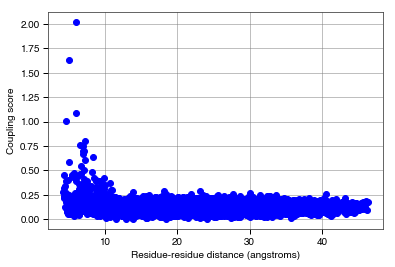

In [7]:
fig,ax = plt.subplots()
ax.plot(merged_df['distance'], (merged_df['couplings']), 'bo')
ax.set_xlabel('Residue-residue distance (angstroms)')
ax.set_ylabel('Coupling score')
print(stats.spearmanr(merged_df['distance'], merged_df['couplings']))

# Varying parameters

In [8]:
contact_number_modifier = 0.5
primary_chain_distance = 12
number_to_test = round(len(df_contacts.index)* contact_number_modifier) 
length_cutoff_CA = 8

####It was just easier to copy/paste these numbers that were calculated in 'analyze_contact_info.ipynb'
length_cutoff_CB = 7.5009365081787109
length_cutoff_SCcenter = 7.3295459747314453

thresholds = [str(i) for i in [0.1, 0.3, 0.5, 0.7, 0.9]]
nMut = len(df_contacts.index)*10
ppvs_dict = {}
metrics = ['CA', 'CB', 'SCcenter']
for metric in metrics:
    if metric == 'CA':
        length_cutoff = length_cutoff_CA
    elif metric == 'CB':
        length_cutoff = length_cutoff_CB
    elif metric == 'SCcenter':
        length_cutoff = length_cutoff_SCcenter

    ppvs_lol = []
    contact_file_loc = '../Data/Contact_matrices/{}_{}_contacts.csv'.format(prot_name, metric)
    df_contacts = pd.read_csv(contact_file_loc, index_col=0)
    df_contacts, df_contacts_stack = process_contacts_df(df_contacts, primary_chain_distance)
    for threshold in thresholds:
        cat_ppvs = []
        for nSeq in list(range(100, 501, 100)) + list(range(1000, 3001, 500)):
            file_loc = '../Data/Simulated_couplings/1AOE_A_thresh={}_nMuts={}_nSeqs={}.ccmpred.processed.couplings'.format(threshold, nMut, nSeq)
            print(file_loc)
            df_couplings = pd.read_csv(file_loc, sep=',')
#             df_couplings.columns = ['aa1_loc', 'trash1', 'aa2_loc', 'trash2', 'trash3', 'couplings']
            df_couplings_stack, df_couplings_pivot = process_couplings_df(df_couplings, df_contacts,\
                                                                          primary_chain_distance)
            merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)
       
            ppv, counts = ppv_from_df(merged_df, number_to_test, length_cutoff=length_cutoff)
            
            ####Testing
            merged_df['contact'] = np.where(merged_df['distance']>=length_cutoff, 0, 1)
            print('PPV', ppv)
            print('AUROC', sklearn.metrics.roc_auc_score(merged_df['contact'], merged_df['couplings']))
            print('Avg Pre',\
                  sklearn.metrics.average_precision_score(merged_df['contact'], merged_df['couplings']))


            cat_ppvs.append(ppv)
        ppvs_lol.append(cat_ppvs)
    ppvs_dict[metric] = ppvs_lol

../Data/Simulated_couplings/1AOE_A_thresh=0.1_nMuts=1920_nSeqs=100.ccmpred.processed.couplings
PPV 0.052083333333333336
AUROC 0.5045188909669865
Avg Pre 0.021210593735748903
../Data/Simulated_couplings/1AOE_A_thresh=0.1_nMuts=1920_nSeqs=200.ccmpred.processed.couplings
PPV 0.07291666666666667
AUROC 0.5000363461039201
Avg Pre 0.028748531531730806
../Data/Simulated_couplings/1AOE_A_thresh=0.1_nMuts=1920_nSeqs=300.ccmpred.processed.couplings
PPV 0.07291666666666667
AUROC 0.5217347582136367
Avg Pre 0.032268341416364504
../Data/Simulated_couplings/1AOE_A_thresh=0.1_nMuts=1920_nSeqs=400.ccmpred.processed.couplings
PPV 0.07291666666666667
AUROC 0.5369532851897574
Avg Pre 0.0355590272302004
../Data/Simulated_couplings/1AOE_A_thresh=0.1_nMuts=1920_nSeqs=500.ccmpred.processed.couplings
PPV 0.13541666666666666
AUROC 0.5493670161756057
Avg Pre 0.045037160339671374
../Data/Simulated_couplings/1AOE_A_thresh=0.1_nMuts=1920_nSeqs=1000.ccmpred.processed.couplings
PPV 0.25
AUROC 0.5791453897139467
Avg Pr

# Paper figure/s

In [9]:
to_analyze_a = 'CB'
to_analyze_b = 'SCcenter'

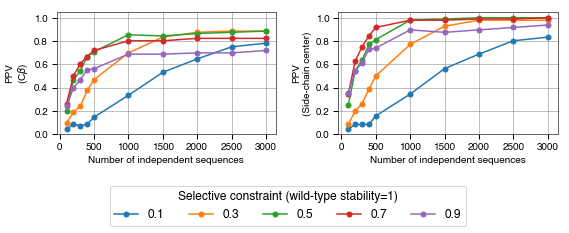

In [10]:
fig, all_ax = plt.subplots(nrows=1, ncols=2, figsize=(8,2.5))
x_vals = np.concatenate((np.arange(100, 501, 100), np.arange(1000, 3001, 500)))
labels = thresholds

ax = all_ax[0]
for i,ppvs in enumerate(ppvs_dict[to_analyze_a]):
    ax.plot(x_vals, ppvs, marker='o', label=thresholds[i], markersize=5)
ax.set_ylim(0,1)

if to_analyze_a == 'CA':
    ax.set_ylabel(r'PPV''\n'r'(C$\alpha$)')
elif to_analyze_a == 'CB':
    ax.set_ylabel(r'PPV''\n'r'(C$\beta$)')
elif to_analyze_a == 'SCcenter':
    ax.set_ylabel(r'PPV''\n'r'(Side-chain center)')

ax.set_xlabel('Number of independent sequences')
ax.set_ylim(0, 1.05);

ax = all_ax[1]
for i,ppvs in enumerate(ppvs_dict[to_analyze_b]):
    ax.plot(x_vals, ppvs, marker='o', label=thresholds[i], markersize=5)
ax.set_ylim(0,1)

if to_analyze_b == 'CA':
    ax.set_ylabel(r'PPV''\n'r'(C$\alpha$)')
elif to_analyze_b == 'CB':
    ax.set_ylabel(r'PPV''\n'r'(C$\beta$)')
elif to_analyze_b == 'SCcenter':
    ax.set_ylabel(r'PPV''\n'r'(Side-chain center)')

ax.set_xlabel('Number of independent sequences')
ax.set_ylim(0, 1.05);
legend = ax.legend(ncol=5, bbox_to_anchor=(-1.07, -0.8, 1., .102), loc=3, fontsize=12,\
                   title='Selective constraint (wild-type stability=1)')
legend.get_title().set_fontsize('12') #legend 'Title' fontsize
plt.tight_layout()


# plt.savefig('{}/example_all_sims_nseqs.pdf'.format(figs_dir), bbox_inches='tight')
# plt.savefig('{}/example_all_sims_nseqs_CB_SC.pdf'.format(figs_dir), bbox_inches='tight')

# Presentation Figure/s

**Preserved here for posterity**

In [11]:
# fig, all_ax = plt.subplots(nrows=1, ncols=2, figsize=(8,2.5))
# x_vals = np.concatenate((np.arange(100, 501, 100), np.arange(1000, 3001, 500)))
# labels = thresholds

# ax = all_ax[0]
# for i,ppvs in enumerate(ppvs_dict[metrics[0]]):
#     if i == 2:
#         ax.plot(x_vals, ppvs, c='g', marker='o', label=thresholds[i], markersize=5)
# ax.set_ylim(0,1)
# ax.set_ylabel(r'PPV''\n'r'(C$\alpha$)')
# ax.set_xlabel('Number of independent sequences')
# ax.set_ylim(0, 1.05);

# ax = all_ax[1]
# for i,ppvs in enumerate(ppvs_dict[metrics[1]]):
#     if i == 2:
#         ax.plot(x_vals, ppvs, c='g', marker='o', label=thresholds[i], markersize=5)
# ax.set_ylim(0,1)
# ax.set_ylabel(r'PPV''\n'r'(Side-chain center)')

# ax.set_xlabel('Number of independent sequences')
# ax.set_ylim(0, 1.05);
# legend = ax.legend(ncol=5, bbox_to_anchor=(-0.6, 1.02, 1., .102), loc=3, fontsize=12, title='Simulation threshold')
# legend.get_title().set_fontsize('12') #legend 'Title' fontsize
# plt.tight_layout()

# # plt.savefig('{}/example_single_sim_nseqs.pdf'.format(figs_dir), bbox_inches='tight')

In [12]:
# fig, ax = plt.subplots(figsize=(4,2.5))
# x_vals = np.concatenate((np.arange(100, 501, 100), np.arange(1000, 3001, 500)))
# labels = thresholds

# for i,ppvs in enumerate(ppvs_dict[metrics[0]]):
#     if i == 2:
#         ax.plot(x_vals, ppvs, c='g', marker='o', label=thresholds[i], markersize=5)
# ax.set_ylim(0,1)
# ax.set_ylabel(r'PPV''\n'r'(C$\alpha$)')
# ax.set_xlabel('Number of independent sequences')
# ax.set_ylim(0, 1.05);
# # legend = ax.legend(ncol=5, bbox_to_anchor=(-0.6, 1.02, 1., .102), loc=3, fontsize=12, title='Simulation threshold')
# legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title='Simulation threshold')
# legend.get_title().set_fontsize('12') #legend 'Title' fontsize
# plt.tight_layout()
# # plt.savefig('{}/example_single_sim_nseqs_left.pdf'.format(figs_dir), bbox_inches='tight')


# fig, ax = plt.subplots(figsize=(4,2.5))
# x_vals = np.concatenate((np.arange(100, 501, 100), np.arange(1000, 3001, 500)))
# labels = thresholds
# for i,ppvs in enumerate(ppvs_dict[metrics[0]]):
#     ax.plot(x_vals, ppvs, marker='o', label=thresholds[i], markersize=5)
# ax.set_ylim(0,1)
# ax.set_ylabel(r'PPV''\n'r'(C$\alpha$)')
# ax.set_xlabel('Number of independent sequences')
# ax.set_ylim(0, 1.05);
# # legend = ax.legend(ncol=5, bbox_to_anchor=(-0.6, 1.02, 1., .102), loc=3, fontsize=12, title='Simulation threshold')
# legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title='Simulation threshold')
# legend.get_title().set_fontsize('12') #legend 'Title' fontsize
# plt.tight_layout()
# # plt.savefig('{}/example_all_sim_nseqs_left.pdf'.format(figs_dir), bbox_inches='tight')


# Fixed sequence number, altered mutation number

In [13]:
contact_number_modifier = 0.5
primary_chain_distance = 12

number_to_test = round(len(df_contacts.index)* contact_number_modifier) 
length_cutoff_CA = 8
length_cutoff_CB = 7.5009365081787109
length_cutoff_SCcenter = 7.3295459747314453
thresholds = [str(i) for i in [0.1, 0.3, 0.5, 0.7, 0.9]]
nSeq = 3000

records = list(SeqIO.parse('../Data/fastas/{}.rosetta.fasta'.format(prot_name), 'fasta'))
assert len(records)==1
seq = str(records[0].seq)

ppvs_dict = {}
metrics = ['CA', 'CB', 'SCcenter']
for metric in metrics:
    if metric == 'CA':
        length_cutoff = length_cutoff_CA
    elif metric == 'CB':
        length_cutoff = length_cutoff_CB
    elif metric == 'SCcenter':
        length_cutoff = length_cutoff_SCcenter


    ppvs_lol = []
    contact_file_loc = '../Data/Contact_matrices/{}_{}_contacts.csv'.format(prot_name, metric)
    df_contacts = pd.read_csv(contact_file_loc, index_col=0)
    df_contacts, df_contacts_stack = process_contacts_df(df_contacts, primary_chain_distance)
    for threshold in thresholds:
        cat_ppvs = []
        for nMut in [0.5] + list(range(1,6,1)) + [10]:
            print(nMut)
            file_loc = '../Data/Simulated_couplings/1AOE_A_thresh={}_nMuts={}_nSeqs={}.ccmpred.processed.couplings'.format(threshold, nMut*len(df_contacts.index), nSeq)
            print(file_loc)
            df_couplings = pd.read_csv(file_loc, sep=',')
#             df_couplings.columns = ['aa1_loc', 'trash1', 'aa2_loc', 'trash2', 'trash3', 'couplings']
            df_couplings_stack, df_couplings_pivot = process_couplings_df(df_couplings, df_contacts, primary_chain_distance)
            merged_df = merge_contacts_couplings(df_contacts_stack, df_couplings_stack, seq)
            ppv, counts = ppv_from_df(merged_df, number_to_test, length_cutoff=length_cutoff)
            cat_ppvs.append(ppv)
        ppvs_lol.append(cat_ppvs)
    ppvs_dict[metric] = ppvs_lol

0.5
../Data/Simulated_couplings/1AOE_A_thresh=0.1_nMuts=96.0_nSeqs=3000.ccmpred.processed.couplings
1
../Data/Simulated_couplings/1AOE_A_thresh=0.1_nMuts=192_nSeqs=3000.ccmpred.processed.couplings
2
../Data/Simulated_couplings/1AOE_A_thresh=0.1_nMuts=384_nSeqs=3000.ccmpred.processed.couplings
3
../Data/Simulated_couplings/1AOE_A_thresh=0.1_nMuts=576_nSeqs=3000.ccmpred.processed.couplings
4
../Data/Simulated_couplings/1AOE_A_thresh=0.1_nMuts=768_nSeqs=3000.ccmpred.processed.couplings
5
../Data/Simulated_couplings/1AOE_A_thresh=0.1_nMuts=960_nSeqs=3000.ccmpred.processed.couplings
10
../Data/Simulated_couplings/1AOE_A_thresh=0.1_nMuts=1920_nSeqs=3000.ccmpred.processed.couplings
0.5
../Data/Simulated_couplings/1AOE_A_thresh=0.3_nMuts=96.0_nSeqs=3000.ccmpred.processed.couplings
1
../Data/Simulated_couplings/1AOE_A_thresh=0.3_nMuts=192_nSeqs=3000.ccmpred.processed.couplings
2
../Data/Simulated_couplings/1AOE_A_thresh=0.3_nMuts=384_nSeqs=3000.ccmpred.processed.couplings
3
../Data/Simulated_co

# Paper figure/s

In [14]:
to_analyze_a = 'CA'
to_analyze_b = 'SCcenter'

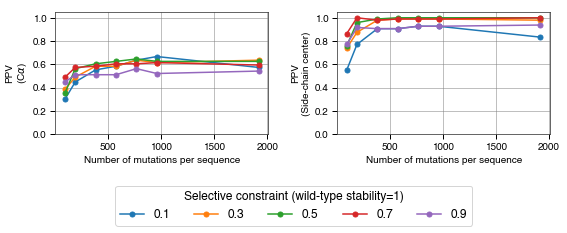

In [15]:
fig, all_ax = plt.subplots(nrows=1, ncols=2, figsize=(8,2.5))
x_vals = [i*len(df_contacts.index) for i in [0.5] + list(range(1,6,1)) + [10]]
labels = thresholds

ax = all_ax[0]
for i,ppvs in enumerate(ppvs_dict[to_analyze_a]):
    ax.plot(x_vals, ppvs, marker='o', label=thresholds[i], markersize=5)

if to_analyze_a == 'CA':
    ax.set_ylabel(r'PPV''\n'r'(C$\alpha$)')
elif to_analyze_a == 'CB':
    ax.set_ylabel(r'PPV''\n'r'(C$\beta$)')
elif to_analyze_a == 'SCcenter':
    ax.set_ylabel(r'PPV''\n'r'(Side-chain center)')


ax.set_xlabel('Number of mutations per sequence')
ax.set_ylim(0, 1.05);

ax = all_ax[1]
for i,ppvs in enumerate(ppvs_dict[to_analyze_b]):
    ax.plot(x_vals, ppvs, marker='o', label=thresholds[i], markersize=5)
ax.set_ylim(0,1)
if to_analyze_b == 'CA':
    ax.set_ylabel(r'PPV''\n'r'(C$\alpha$)')
elif to_analyze_b == 'CB':
    ax.set_ylabel(r'PPV''\n'r'(C$\beta$)')
elif to_analyze_b == 'SCcenter':
    ax.set_ylabel(r'PPV''\n'r'(Side-chain center)')


ax.set_xlabel('Number of mutations per sequence')
ax.set_ylim(0, 1.05);
legend = ax.legend(ncol=5, bbox_to_anchor=(-1.07, -0.8, 1., .102), loc=3, fontsize=12,\
                   title='Selective constraint (wild-type stability=1)')
legend.get_title().set_fontsize('12') #legend 'Title' fontsize
plt.tight_layout()

# plt.savefig('{}/example_all_sims_nmuts.pdf'.format(figs_dir), bbox_inches='tight')
# plt.savefig('{}/example_all_sims_nmuts_CB_SC.pdf'.format(figs_dir), bbox_inches='tight')

# Presentation figures

**Again, only here for posterity**

In [16]:
# fig, all_ax = plt.subplots(nrows=1, ncols=2, figsize=(8,2.5))
# x_vals = [i*len(df_contacts.index) for i in [0.5] + list(range(1,6,1)) + [10]]
# labels = thresholds

# ax = all_ax[0]
# for i,ppvs in enumerate(ppvs_dict[metrics[0]]):
#     if i == 2:
#         ax.plot(x_vals, ppvs, marker='o', c='g', label=thresholds[i], markersize=5)
# ax.set_ylabel(r'PPV''\n'r'(C$\alpha$)')
# ax.set_xlabel('Number of mutations per sequence')
# ax.set_ylim(0, 1.05);

# ax = all_ax[1]
# for i,ppvs in enumerate(ppvs_dict[metrics[1]]):
#     if i == 2:
#         ax.plot(x_vals, ppvs, marker='o', c='g', label=thresholds[i], markersize=5)
# ax.set_ylim(0,1)
# ax.set_ylabel(r'PPV''\n'r'(Side-chain center)')

# ax.set_xlabel('Number of mutations per sequence')
# ax.set_ylim(0, 1.05);
# legend = ax.legend(ncol=5, bbox_to_anchor=(-1, 1.02, 1., .102), loc=3, fontsize=12,\
#                    title='Selective constraint (wild-type stability=1)')
# legend.get_title().set_fontsize('12') #legend 'Title' fontsize
# plt.tight_layout()

# # plt.savefig('{}/example_single_sim_nmuts.pdf'.format(figs_dir), bbox_inches='tight')